In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
import numba
import molsim

<div style="max-width: 1000px; margin-left: 0; margin-right: auto; line-height: 1.6;">

# Exercise 1: Distribution of particles

Consider an ideal gas of N particles in a constant volume at constant energy. Let us divide the volume in p identical compartments. Every compartment contains ni molecules such that

\begin{equation}
N = \sum^{i=p}_{i=1}n_i
\end{equation}

An interesting quantity is the distribution of molecules over the $p$ compartments. Because the energy is constant, every possible eigenstate of the system will be equally likely. This means that in principle it is possible that one of the compartments is empty.



<img src="./figure/compartments.png" alt="示例图片" style="display: block; margin: auto;" width="250">


**Figure 1.An ideal gas of $N=1000$ particles in a constant volume at constant energy. The volume is divided into $p=81$ compartments. The snapshot is obtained by randomly distributing $N=1000$ particles over $p=81$ compartments.**

<div style="max-width: 1000px; margin-left: 0; margin-right: auto; line-height: 1.6;">

# Question 1: 
Enclosed is a program that calculates the distribution of
molecules along the $p$ compartments.

Step 1: Complete the code first and set parameters;

Step 2: Run the program; the output of the program is the probability to find $x$ particles in a particular compartment as a function of $x$; 

Step 3: Plot the outputs. 

Run the program with different numbers of compartments ($p$) and total number of gas molecules ($N$). Describe and discuss the characteristics of the distributions. 

</div>

In [ ]:
numberOfParticles = 1000
numberOfCompartments = 10
numberOfCycles = 1000

probabilities = np.ones(numberOfCompartments) / numberOfCompartments

particlesInCompartment = np.zeros((numberOfCycles, numberOfCompartments), dtype=np.int32)

In [27]:
def splitParticlesAcrossCompartments(numberOfParticles: int, numberOfCompartments: int, probabilities: np.ndarray, nummberOfCycles: int):
    assert np.allclose(np.sum(probabilities), 1), "Probabilities do not sum to 1" 
    
    #Create the numberOfCycles x numberOfCompartments matrix
    particlesArrayBroadcasted = np.ones((nummberOfCycles, 1), dtype=np.int32)*numberOfParticles
    
    #Compute the raw allocations following the distribution provided
    rawAllocations = particlesArrayBroadcasted @ probabilities.reshape(1, numberOfCompartments)

    #Floor all allocations in order to compute a reaminder
    integerAllocations = np.floor(rawAllocations).astype(np.int32)
    
    #Compute the remainder
    remainder = particlesArrayBroadcasted - np.sum(integerAllocations, axis=1, dtype=np.int32).reshape(nummberOfCycles, 1)
    
    #Compute the fractional parts
    fractionalParts = rawAllocations - integerAllocations
    
    #Sort the fractional parts
    indicesInDescendingOrder = np.argsort(fractionalParts, axis=1)[:, ::-1]
    
    #Distribute the remainders across the smaller numbers
    for j in range(numberOfCycles):
        for i in range(remainder[j, 0]):
            integerAllocations[j, indicesInDescendingOrder[j, i]] += 1
    
    #Check that the sum of allocations is equal to the total number of particles
    assert np.allclose(particlesArrayBroadcasted, np.sum(integerAllocations, axis=1, dtype=np.int32).reshape(numberOfCycles, 1)), "Sum of allocations is not equal to total number of particles"
    return integerAllocations

particlesInCompartment = splitParticlesAcrossCompartments(numberOfParticles, numberOfCompartments, probabilities, numberOfCycles)


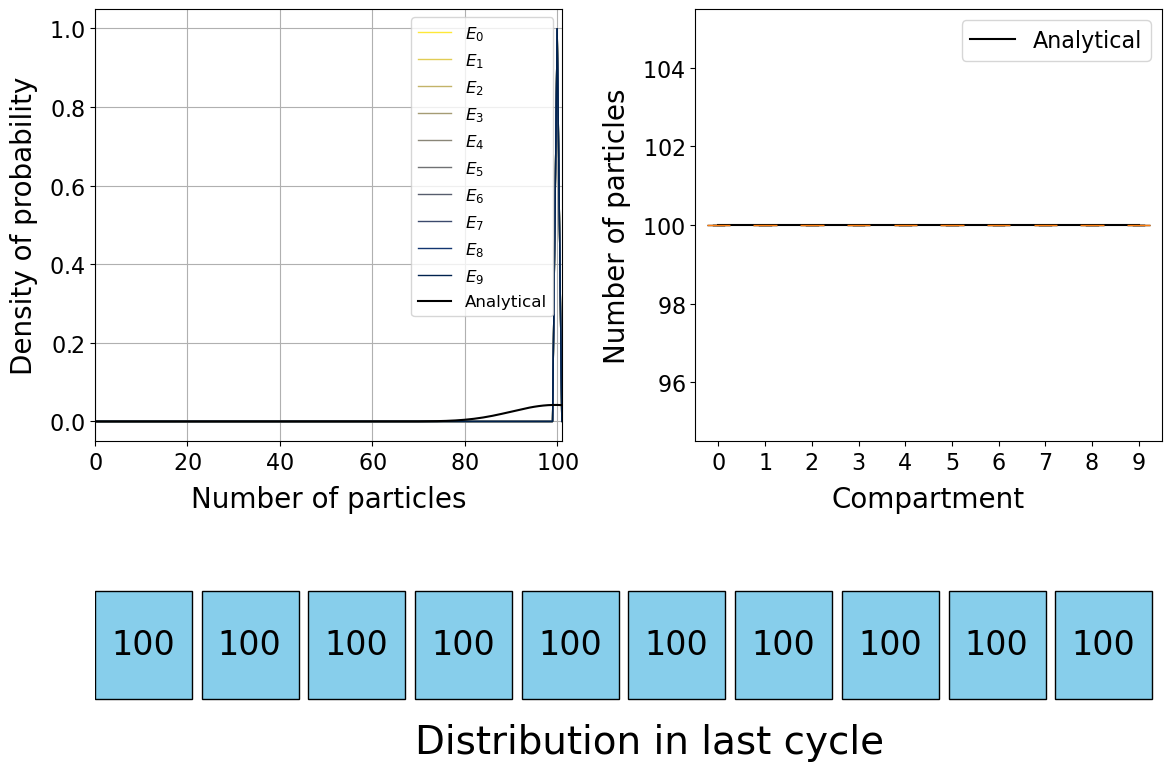

In [28]:
def lastNonZero(series: np.ndarray):
    # Find the index of the last non-zero element in the series
    return len(series) - np.where(series[::-1] > 0)[0][0]


def plotDistribution(
    particlesInCompartment: np.ndarray,
    numberOfParticles: int,
    analyticalParticleDistribution: np.ndarray = None,
    analyticalCompartmentDistribution: np.ndarray = None,
):
    """Plot the distribution of particles in compartments

    Paramters:
        - particlesInCompartment (np.ndarray): Array containing the number of particles in each compartment for each cycle.
        - numberOfParticles (int): Total number of particles.
        - analyticalParticleDistribution (np.ndarray, optional): Analytical distribution of particles. Defaults to None.
        - analyticalCompartmentDistribution (np.ndarray, optional): Analytical distribution of compartments. Defaults to None.

    Returns:
        - None
    """

    numberOfCompartments = particlesInCompartment.shape[1]
    colors = plt.cm.cividis(np.linspace(1, 0, numberOfCompartments))

    # Create a figure with a custom gridspec
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])  # Two rows, two columns, bottom row is taller

    # Create the subplots
    ax0 = fig.add_subplot(gs[0, 0])  # Top-left
    ax1 = fig.add_subplot(gs[0, 1])  # Top-right
    ax2 = fig.add_subplot(gs[1, :])  # Bottom, spanning both columns

    # Calculate the distribution of particles in each compartment
    totalDistribution = np.zeros(numberOfParticles)
    for c in range(numberOfCompartments):
        distribution, _ = np.histogram(
            particlesInCompartment[:, c], bins=numberOfParticles, range=(-0.5, numberOfParticles + 0.5), density=True
        )
        ax0.plot(distribution, label=f"$E_{{{c}}}$", c=colors[c], lw=1)
        totalDistribution += distribution

    # Plot the analytical distribution if provided
    if analyticalParticleDistribution is not None:
        ax0.plot(analyticalParticleDistribution, label="Analytical", c="black")

    ax0.set_xlabel("Number of particles", fontsize=20)
    ax0.set_ylabel("Density of probability", fontsize=20)
    ax0.set_xlim(0, lastNonZero(totalDistribution))
    ax0.legend(fontsize=12)

    # Plot the distribution of particles in each compartment
    ax1.boxplot(
        particlesInCompartment,
        patch_artist=True,
        boxprops=dict(facecolor="skyblue"),
        tick_labels=np.arange(numberOfCompartments),
    )
    ax1.set_xlabel("Compartment", fontsize=20)
    ax1.set_ylabel("Number of particles", fontsize=20)
    if analyticalCompartmentDistribution is not None:
        ax1.plot(np.arange(numberOfCompartments) + 1, analyticalCompartmentDistribution, label="Analytical", c="black")
    ax1.grid(False)
    ax1.legend()

    # Plot the distribution of particles in the last cycle
    ax2.axis("off")
    ax2.text(0.3, 0.0, "Distribution in last cycle", fontsize=28)
    for i, val in enumerate(particlesInCompartment[-1]):
        ax2.add_patch(
            plt.Rectangle(
                (i / numberOfCompartments, 0.25),
                1 / (numberOfCompartments + 1),
                0.5,
                edgecolor="black",
                facecolor="skyblue",
            )
        )
        ax2.text(
            ((i + 0.45) / numberOfCompartments), 0.5, str(val), fontsize=24, ha="center", va="center", color="black"
        )

    fig.tight_layout()


def analyticalParticleDistribution(numberOfParticles: int, numberOfCompartments: int):
    """Calculate the analytical distribution of particles in compartments"""

    # get index array
    idx = np.arange(numberOfParticles)

    # get binomial coefficients npr(N, j) in array
    binomCoeffs = scipy.special.binom(numberOfParticles, idx)

    # precompute p
    p = 1 / numberOfCompartments

    # return binomial pmf
    return binomCoeffs * p**idx * (1 - p) ** (numberOfParticles - idx)


plotDistribution(
    particlesInCompartment,
    numberOfParticles,
    analyticalParticleDistribution(numberOfParticles, numberOfCompartments),
    np.ones(numberOfCompartments) * (numberOfParticles / numberOfCompartments),
)

<div style="max-width: 1000px; margin-left: 0; margin-right: auto; line-height: 1.6;">

# Question 2:

Why does it (almost) never happen that one of the compartments is empty when $N/P ≫ 1$?
</div>

---

### Answer

Assuming that none of the compartments has a zero-probability assigned to them, then when $N \gg P$ there will be definitely be a particle assigned to that compartment. Therefore, when $N \gg P$, the probability of a compartment being empty is zero.
